In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import dwave_networkx as dnx
import pandas as pd
import numpy as np
import json
from music21 import stream, converter, instrument, tinyNotation, environment
#us = environment.UserSettings()
#us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
#us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'

from colours import Tableau as T
from LBDM import calculateStrengths
from plots import plotBoundaryStrength, plotLagrange, plotCSV
from qubo import createBQM

plt.style.use("thesis.mplstyle")

picklePath = lambda id : f"../Pickles/{id}/{id}_"
numberPath = lambda id, num : f"../Pickles/{id}/{num}/{id}_{num}_"
dataPath = lambda id, num : f"../Data/{id}/{num}/{id}_{num}_"

### Phrase extraction

In [ ]:
phrases = pd.read_csv(picklePath("haydn-op1") + "phrases.csv", index_col=[0,1])
print(len(phrases))

phrases = pd.read_csv(picklePath("beethoven-op67") + "phrases.csv", index_col=[0,1])
print(len(phrases))

192
127


In [2]:
score = converter.parse(picklePath("haydn-op1") + "score.musicxml")
part = score.parts[0]
df = calculateStrengths(part, 0.3, (0.33, 0.66))

print(len(df.query("IsBoundary")))

plt.figure(1, figsize=(8,3))
plotBoundaryStrength(df, 0.3)
plt.savefig("../Figures/haydn-lbdm.svg")

score = converter.parse(picklePath("beethoven-op67") + "score.musicxml")
part = score.parts[7]
df = calculateStrengths(part, 0.25, (0.33, 0.66))

plt.figure(2)
plotBoundaryStrength(df, 0.25)
plt.savefig("../Figures/beethoven-lbdm.svg")

NameError: name 'converter' is not defined

### Lagrange parameters

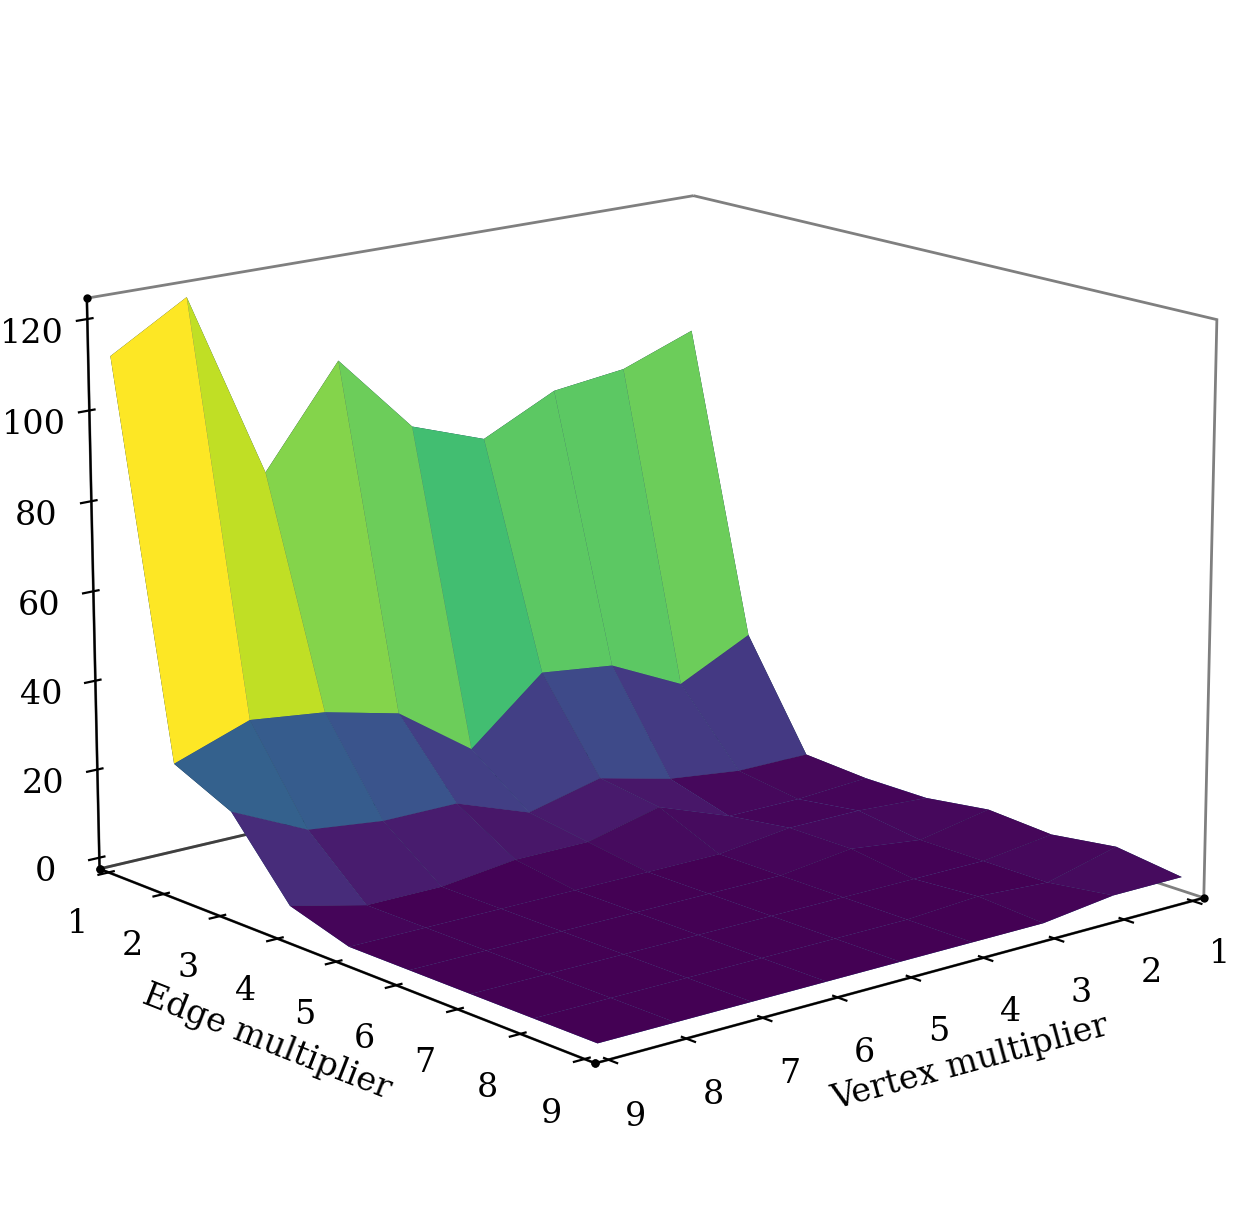

In [ ]:
data = pd.read_csv(dataPath("haydn-op1", 2) + "lagrange.csv")

plotLagrange(data)
#plt.savefig("../Figures/haydn-lagrange.svg")

### Solver configuration

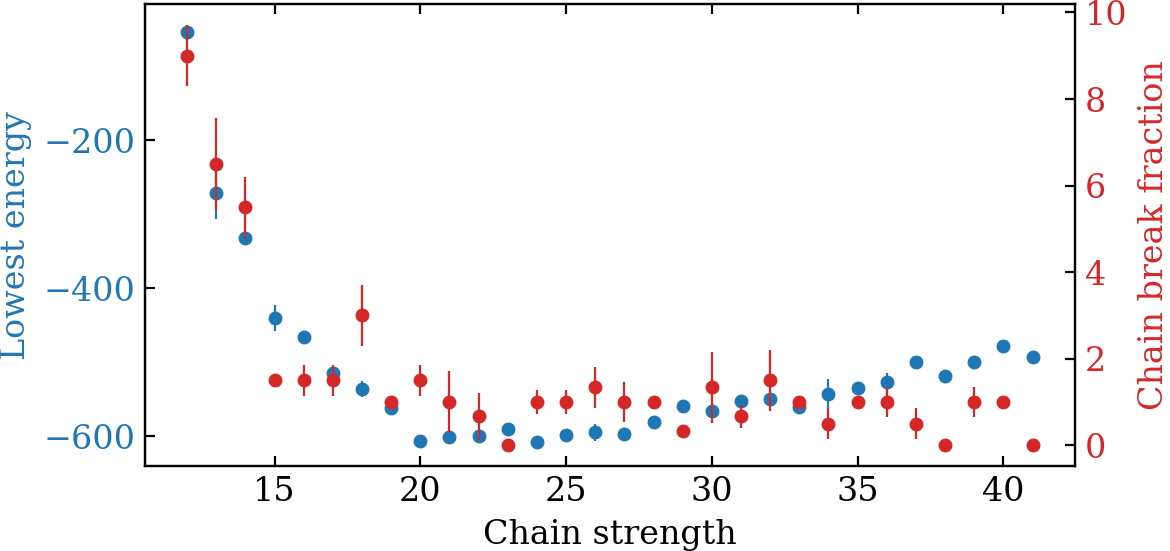

In [2]:
data = pd.read_csv(dataPath("haydn-op1", 3) + "chain-strength.csv")

#plotCSV(dataPath("haydn-op1", 3) + "chain-strength.csv", "Chain strength", "Chain break fraction")
#plotCSV(dataPath("haydn-op1", 3) + "chain-strength.csv", "Chain strength", "Lowest energy")

def meanAndStderr(df: pd.DataFrame, xaxis: str, yaxis: str):
    x = df[xaxis].unique()
    queries = [data.query(f"`{xaxis}` == {r}")[yaxis] for r in x]

    mean = np.array([np.mean(q) for q in queries])
    stderr = np.array([np.std(q)/np.sqrt(len(q)) for q in queries])

    return x, mean, stderr


fig, ax1 = plt.subplots(figsize=(6,3))

x, mean, stderr = meanAndStderr(data, "Chain strength", "Lowest energy")

color = 'tab:blue'
ax1.set_xlabel("Chain strength")
ax1.set_ylabel("Lowest energy", color=color)
ax1.errorbar(x, mean, yerr=stderr, fmt='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
x, dupl, stderr = meanAndStderr(data, "Chain strength", "Duplicates")
x, ovlp, stderr = meanAndStderr(data, "Chain strength", "Overlaps")
mean = dupl + ovlp

color = 'tab:red'
ax2.set_ylabel("Chain break fraction", color=color)
ax2.errorbar(x, mean, yerr=stderr, fmt='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

#plt.savefig("../Figures/haydn-chain-strength.svg")

(0.53, 0.61)

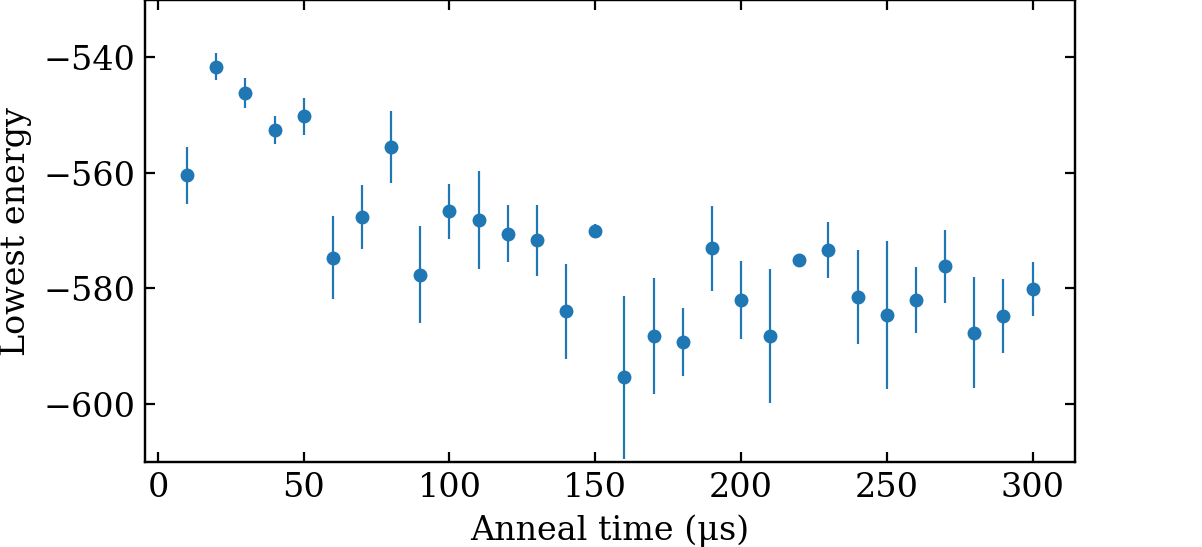

In [3]:
data = pd.read_csv(dataPath("haydn-op1", 3) + "anneal-time.csv")

fig, ax1 = plt.subplots(figsize=(6,3))

x, mean, stderr = meanAndStderr(data, "Anneal time", "Lowest energy")

ax1.set_xlabel("Anneal time (μs)")
ax1.set_ylabel("Lowest energy")
ax1.errorbar(x, mean, yerr=stderr, fmt='o', color='tab:blue')
ax1.set_ylim(-610,-530)

ax2 = ax1.twinx()
ax2.set_ylabel(" ")
ax2.tick_params(axis='y', labelcolor="white")
ax2.set_ylim(0.53, 0.61)

#plt.savefig("../Figures/haydn-anneal-time.svg")

### Compare to classical

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Lucas\AppData\Local\Temp\ipykernel_14152\2160134490.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plotCompareClassical("Lowest energy").show()#savefig("../Figures/compare-reads.svg")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


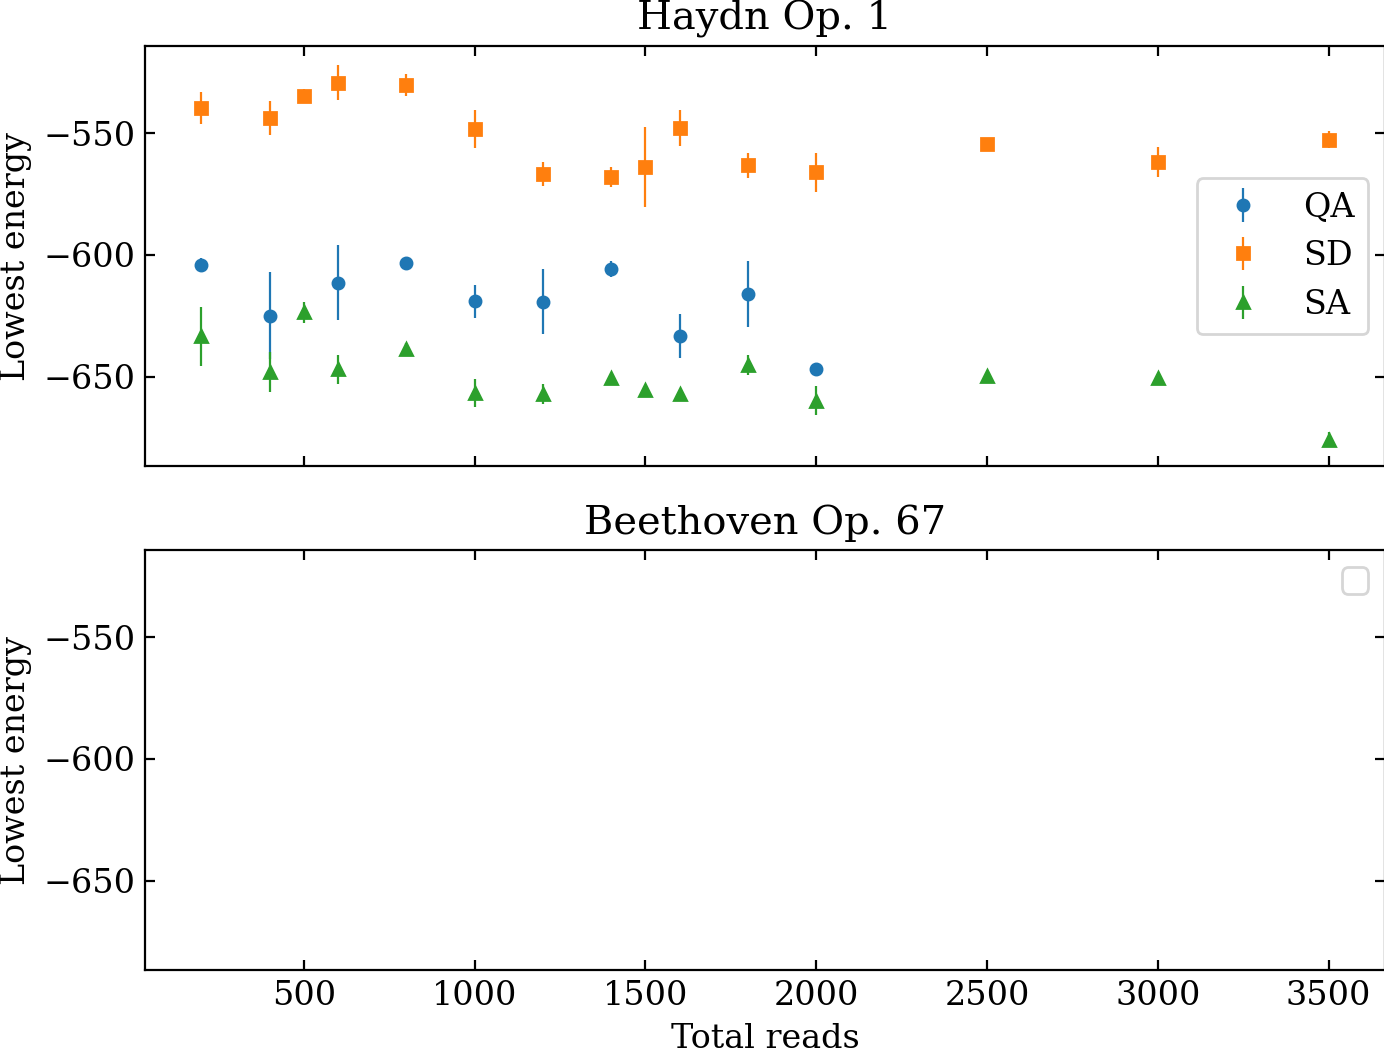

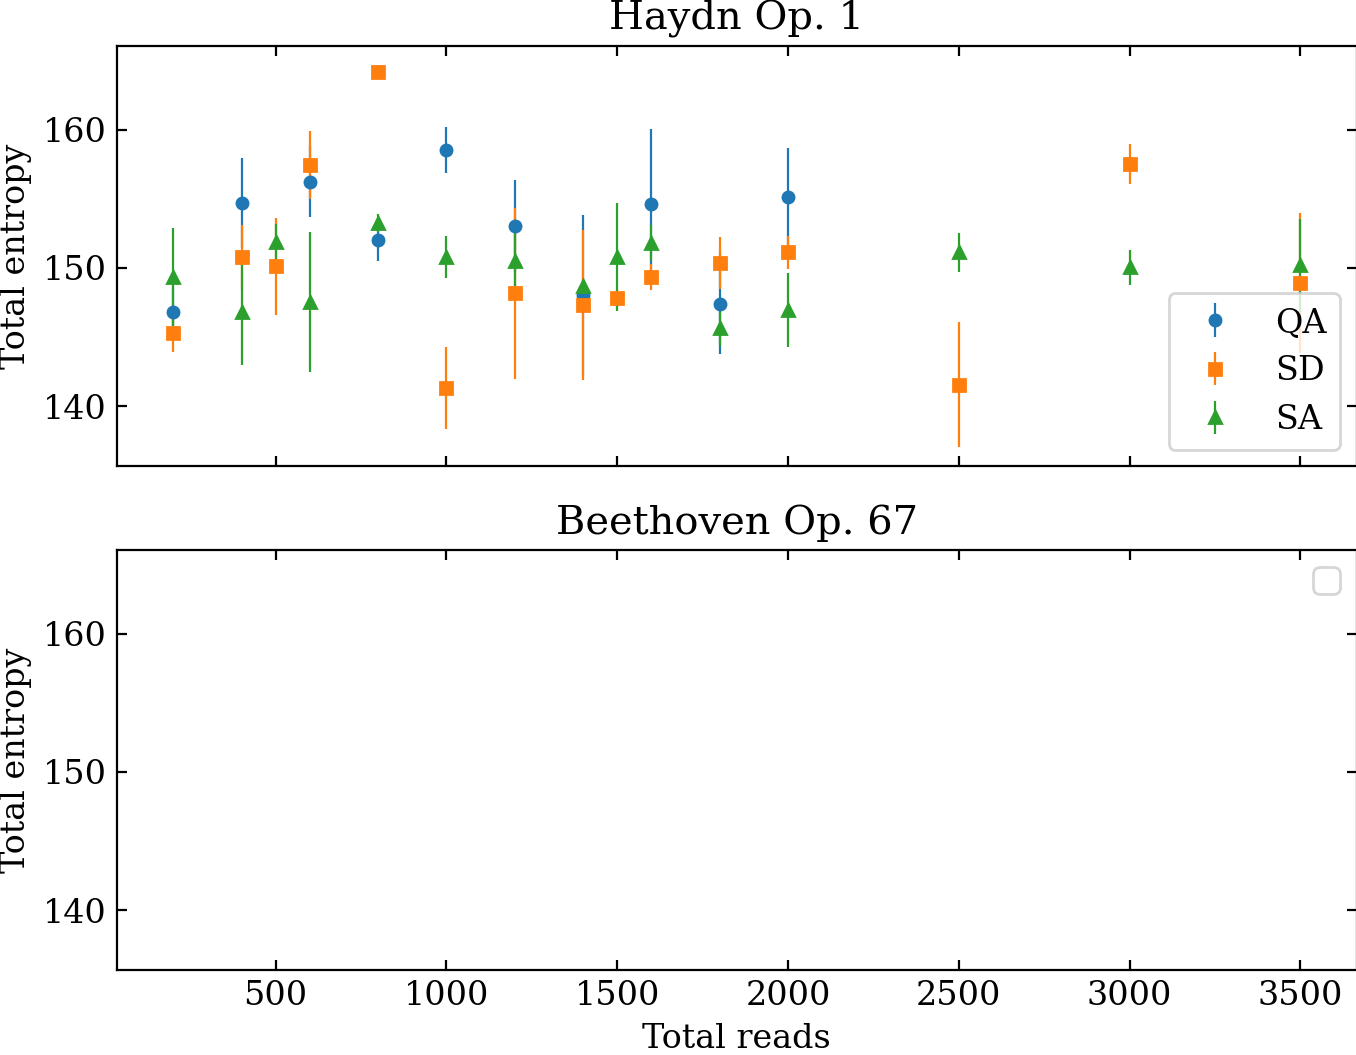

In [4]:
def plotCSV(filepath: str, xaxis: str, yaxis: str, axis, colour, label: str = "", marker: str = "o") -> None:

    data = pd.read_csv(filepath)
    x = data[xaxis].unique()

    means = []
    stderr = []

    for r in x:
        query = data.query(f"`{xaxis}` == {r}")[yaxis]
        means.append(np.mean(query))
        stderr.append(np.std(query)/np.sqrt(len(query)))

    axis.errorbar(x, means, yerr=stderr, fmt=marker, label=label, c=colour)
    #axis.set_xlabel(xaxis)
    #axis.set_ylabel(yaxis)

def plotCompareClassical(yaxis: str):

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,6))

    fp = dataPath("haydn-op1",3)
    plotCSV(fp+"qa-reads.csv", "Total reads", yaxis, ax1, "tab:blue", "QA", "o")
    plotCSV(fp+"sd-reads.csv", "Total reads", yaxis, ax1, "tab:orange", "SD", "s")
    plotCSV(fp+"sa-reads.csv", "Total reads", yaxis, ax1, "tab:green", "SA", "^")
    ax1.set_title("Haydn Op. 1")
    ax1.legend()
    ax1.set_ylabel(yaxis)


    ax2.set_title("Beethoven Op. 67")
    ax2.legend()
    ax2.set_xlabel("Total reads")
    ax2.set_ylabel(yaxis)

    return fig

plotCompareClassical("Lowest energy").show()#savefig("../Figures/compare-reads.svg")
plotCompareClassical("Total entropy").savefig("../Figures/compare-entropy.svg")


### Scaling

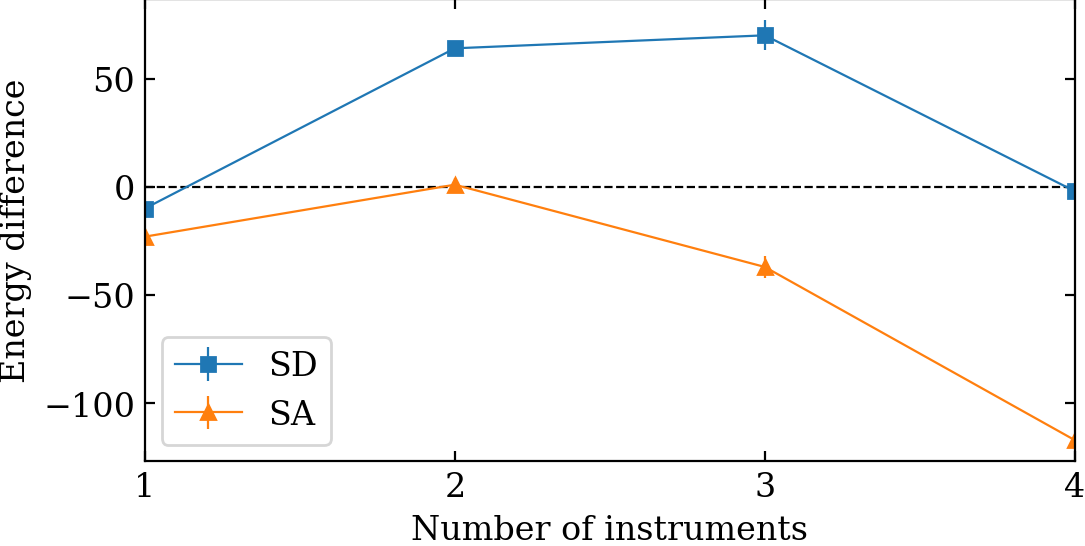

In [41]:
insts = np.arange(4)
reads = 1000
yaxis = "Lowest energy"

qa = np.empty_like(insts)
qaerr = np.empty_like(insts)
sd = np.empty_like(insts)
sderr = np.empty_like(insts)
sa = np.empty_like(insts)
saerr = np.empty_like(insts)

for i in insts:

    fp = dataPath("haydn-op1", i+1)
    data = pd.read_csv(fp+"qa-reads.csv")
    query = data.query(f"`Total reads` == {reads}")[yaxis]
    qa = np.mean(query)
    qaerr[i] = np.std(query)/np.sqrt(len(query))

    data = pd.read_csv(fp+"sd-reads.csv")
    query = data.query(f"`Total reads` == {reads}")[yaxis]
    sd[i] = np.mean(query) - qa
    sderr[i] = np.std(query)/np.sqrt(len(query))

    data = pd.read_csv(fp+"sa-reads.csv")
    query = data.query(f"`Total reads` == {reads}")[yaxis]
    sa[i] = np.mean(query) - qa
    saerr[i] = np.std(query)/np.sqrt(len(query))

plt.figure(figsize=(6,3))
#plt.errorbar(insts+1, qa, yerr=qaerr, label="QA")
plt.errorbar(insts+1, sd, yerr=sderr, label="SD", marker="s")
plt.errorbar(insts+1, sa, yerr=saerr, label="SA", marker="^")
plt.hlines(0, 1, 4, linestyles="--", colors="black")
plt.xlabel("Number of instruments")
plt.ylabel("Energy difference")
plt.xlim(1,4)
plt.xticks(insts+1)
plt.legend()

plt.savefig("../Figures/scaling.svg")

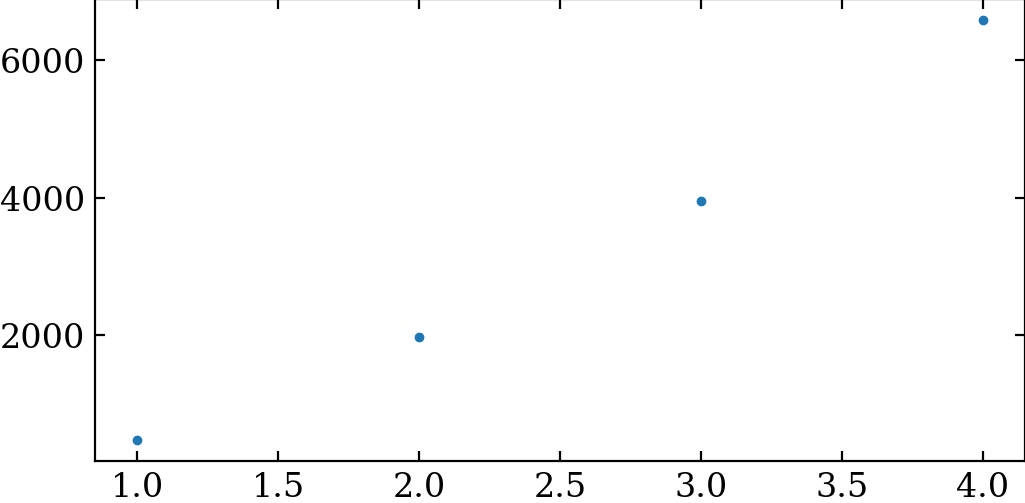

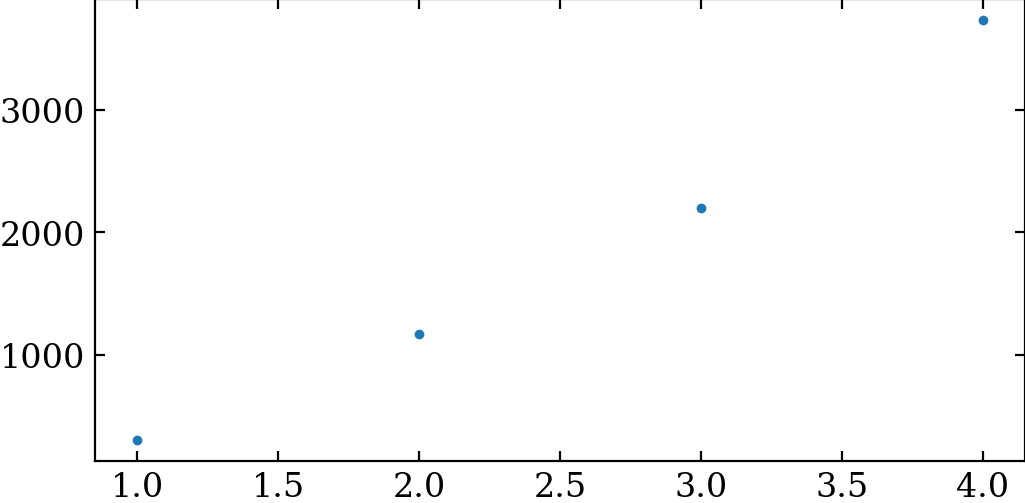

In [32]:
insts = np.arange(4)

phrases = pd.read_csv(picklePath("haydn-op1") + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(picklePath("haydn-op1") + "graph.graphml")

quadratic = np.empty_like(insts)
embeddings = np.empty_like(insts)

for i in insts:
    instruments = json.load(open(numberPath("haydn-op1", i+1) + "instruments.json"))
    fp = dataPath("haydn-op1", i+1)
    data = pd.read_csv(fp+"qa-reads.csv")

    bqm = createBQM(G, phrases, instruments)
    quadratic[i] = len(bqm.quadratic)
    
    embedding = json.load(open(numberPath("beethoven-op67", i+1) + "embedding.json", "r"))
    embeddings[i] = sum(len(e) for e in embedding.values())

plt.scatter(insts+1, quadratic)
plt.show()
plt.scatter(insts+1, embeddings)

### Pegasus architecture

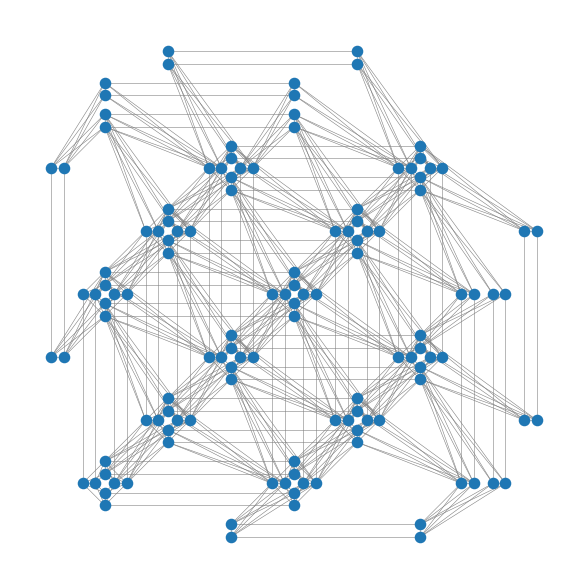

In [17]:
P = dnx.pegasus_graph(3)
#fig, ax = plt.subplots(layout="constrained")
dnx.draw_pegasus(P, with_labels=False, node_size = 10, width=0.2, crosses=True, node_color="tab:blue", edge_color="gray")
plt.gca().set_aspect('equal')
plt.savefig("..\Figures\pegasus.svg")

### Toy score

In [ ]:
class ColorModifier(tinyNotation.Modifier):
    def postParse(self, m21Obj):
        m21Obj.style.color = self.modifierData
        return m21Obj

tnc = tinyNotation.Converter()
tnc.modifierAngle = ColorModifier

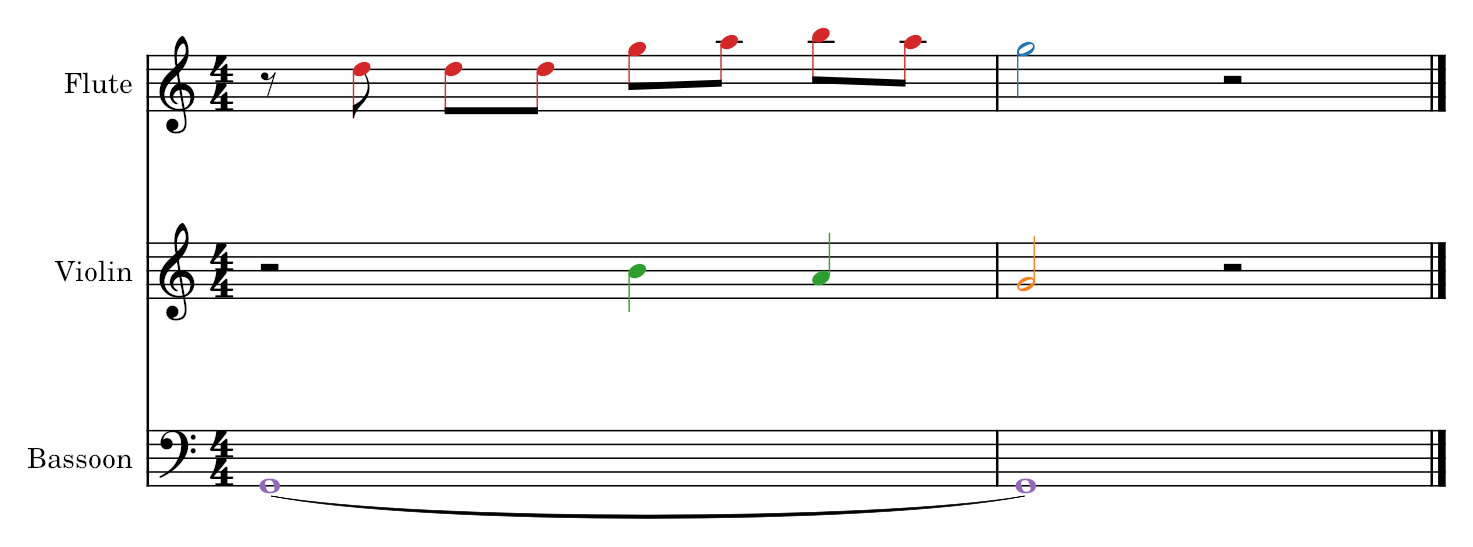

In [3]:
# Toy example score
f1 = T.RED.value
f2 = T.BLUE.value
v1 = T.GREEN.value
v2 = T.ORANGE.value
b1 = T.PURPLE.value

toy = stream.Score()

flute = converter.parse("tinyNotation: 4/4 r8 d' d' d' g' a' b' a' g'2 r")
for el in flute.flatten().getElementsByOffset(0.5,3.5):
    el.style.color = f1
for el in flute.flatten().getElementsByOffset(4,5):
    el.style.color = f2
flute.insert(0,instrument.Flute())
toy.insert(0,flute)

violin = converter.parse("tinyNotation: 4/4 r2 b4 a4 g2 r")
for el in violin.flatten().getElementsByOffset(2,3):
    el.style.color = v1
for el in violin.flatten().getElementsByOffset(4,5):
    el.style.color = v2
violin.insert(0,instrument.Violin())
toy.insert(0,violin)

bassoon = converter.parse("tinyNotation: 4/4 GG1~ GG1")
bassoon.insert(0,instrument.Bassoon())
for el in bassoon.flatten().notes:
    el.style.color = b1
toy.insert(0,bassoon)

toy.show(leaveMargin=50)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_trim.png", dpi=300)
#toy.write(fmt="musicxml.png", fp="../Figures/toy.png", dpi=300, leaveMargin=50)

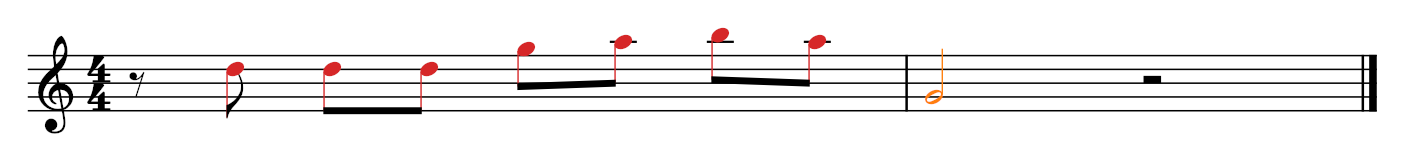

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Figures/toy_arrangement-1.png')

In [ ]:
# Toy selected score
toy = stream.Score()

arrangement = converter.parse("tinyNotation: 4/4 r8 d' d' d' g' a' b' a' g2 r")
for el in arrangement.flatten().getElementsByOffset(0.5,3.5):
    el.style.color = f1
for el in arrangement.flatten().getElementsByOffset(4,5):
    el.style.color = v2
toy.insert(0,arrangement)

toy.show(leaveMargin=50)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_arrangement_trim.png", dpi=300)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_arrangement.png", dpi=300, leaveMargin=50)

(np.float64(-1.209829125202103),
 np.float64(1.2082017461745111),
 np.float64(-0.7538426581005653),
 np.float64(0.7553152653763618))

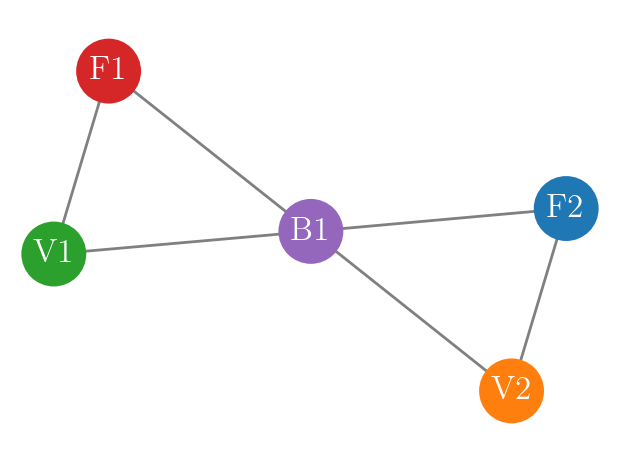

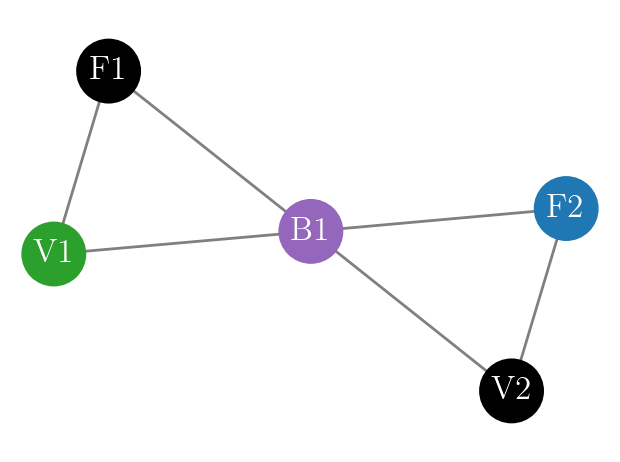

In [4]:
# Toy example graph

edges = [("F1","V1"), ("V1","B1"), ("F1","B1"), ("F2","V2"), ("V2","B1"), ("F2","B1")]

F = nx.Graph()
F.add_edges_from(edges)

colours = [f1, v1, b1, f2, v2]

pos = nx.spring_layout(F, seed=1)
plt.figure(0)
nx.draw_networkx(F, pos=pos, edge_color="gray", width=1, font_color="white", node_size=500, node_color=colours, hide_ticks=True)
plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
#plt.savefig("..\Figures\\toy_graph.svg")

plt.figure(1)
selected = ["F1", "V2"]
nx.draw_networkx(F, pos=pos, edge_color="gray", width=1, font_color="white", node_size=500, node_color=["black",v1,b1,f2,"black"], hide_ticks=True)
plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
#plt.savefig("..\Figures\\toy_solution.pgf")